In [1]:
import datetime
import gc
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import scipy.stats
import seaborn as sns
import sys
sys.path.append("../")
import time
import warnings
warnings.simplefilter("ignore")
from itertools import repeat
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [2]:
from utils.common import (
    sigmoid, pad_column_name
)
from utils.constants import (
    RAW_DATA_PATH, PROCESSED_DATA_PATH
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, plot_heatmap,
    get_cols
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, FIRST_FEATURES,
    RANGE_FEATURES, VELOCITY_FEATURES, SPEED_FEATURES
)
from utils.feature_engineering_helpers import (
    filter_df_for_feature, 
    get_specific_row_df, 
    get_agg_df, get_ma_df
)

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [4]:
%load_ext autoreload
%autoreload

## Feature Engineering on Train

### Read master data & train labels

In [26]:
%%time
raw_train = read_file(f"{RAW_TRAIN_PICKLE_PATH}/train_data.pkl")
# raw_train = read_file(f"{PROCESSED_DATA_PATH}/train_agg_complete2.pkl")

Shape of data: (5531451, 193)
CPU times: user 1.57 s, sys: 2.08 s, total: 3.65 s
Wall time: 5.78 s


In [27]:
labels = read_file(f"{RAW_DATA_PATH}/train_labels.csv")

Shape of data: (458913, 2)


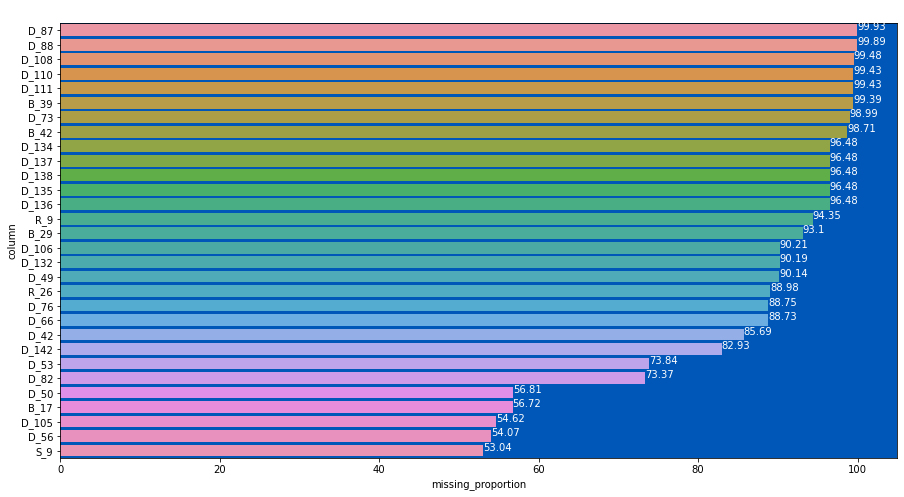

In [28]:
m = plot_missing_proportion_barchart(raw_train)

In [31]:
high_missing_cols = m.loc[m["missing_proportion"] > 5]["column"].tolist()
low_missing_cols = m.loc[m["missing_proportion"] <= 5]["column"].tolist()

In [32]:
raw_train = raw_train.drop(columns=high_missing_cols, errors="ignore")

In [33]:
# m = plot_missing_proportion_barchart(raw_train)

In [34]:
for col in tqdm(low_missing_cols):
    try:
        imputed_series = raw_train[col].fillna(raw_train[col].mean())
    except:
        imputed_series = raw_train[col].fillna(raw_train[col].mode().values[0])
    raw_train[col] = imputed_series

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:09<00:00,  8.27it/s]


In [98]:
raw_train_number_df = raw_train.select_dtypes(np.float32)

In [76]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [92]:
def pad_array(array):
    return np.pad(array, (13-len(array), 0))

In [94]:
p2_array_df["P_2"] = p2_array_df["P_2"].parallel_apply(lambda x: pad_array(x))

In [103]:
col = raw_train_number_df.columns[0]

In [105]:
master_df = raw_train.groupby("customer_ID")[col].apply(np.array)

In [107]:
# for col in raw_train_number_df.columns[1:]:
#     temp_df = raw_train.groupby("customer_ID")[col].apply(np.array)
#     master_df = pd.concat([master_df, temp_df], axis=1)
#     print(f"{col} done")
#     gc.collect()

In [172]:
%%time
master_numeric_array_df = master_df.reset_index()

In [173]:
# %%time
# master_numeric_array_df.to_csv(f"{PROCESSED_DATA_PATH}/train_time_series66.csv", index=False)

In [174]:
# %%time
# master_numeric_array_df.to_pickle(f"{PROCESSED_DATA_PATH}/train_time_series66.pkl")

In [175]:
%%time
for col in master_numeric_array_df.columns[1:]:
    master_numeric_array_df[col] = master_numeric_array_df[col].parallel_apply(lambda x: pad_array(x))

CPU times: user 2min 19s, sys: 1min 8s, total: 3min 28s
Wall time: 4min 18s


In [176]:
def stack_all_columns(row):
    return np.stack(row.values, axis=0).T.reshape(13, 66)

In [178]:
%%time
master_numeric_array_df["input"] = master_numeric_array_df.iloc[:, 1:].parallel_apply(lambda x: stack_all_columns(x), axis=1)

CPU times: user 1min 11s, sys: 32.3 s, total: 1min 44s
Wall time: 2min 5s


In [ ]:
master_numeric_array_df["input"]

0         [[0.9384687, 0.008724451, 1.0068382, 0.0092277...
1         [[0.9291219, 0.025781533, 1.0026472, 0.0055147...
2         [[0.87661546, 0.001472054, 0.8107964, 0.005954...
3         [[0.5674418, 0.0703109, 0.81205267, 0.00422761...
4         [[0.9368416, 0.0034334608, 0.8186911, 0.007242...
                                ...                        
458908    [[0.8598694, 0.0060839406, 1.0006903, 0.009374...
458909    [[0.8631529, 0.43140754, 0.030639106, 0.004702...
458910    [[0.79372376, 0.06387534, 1.0088072, 0.0076202...
458911    [[0.85698086, 0.003493784, 1.0059701, 0.005690...
458912    [[0.9990566, 0.11947775, 1.0097076, 0.00240899...
Name: input, Length: 458913, dtype: object

In [180]:
X_train = np.stack(master_numeric_array_df["input"])

In [181]:
y_train = labels["target"].values

In [ ]:
model = Sequential()
model.add(GRU(activation='tanh', input_shape=(13, 66)))
model.add(Conv1D(filters=8, kernel_size=3, activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
X_train.shape, y_train.shape

### Oversampling / Undersampling (SMOTE)

In [190]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

In [191]:
resample = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'))

In [203]:
X_train[:, :, 0].shape

(458913, 13)

In [230]:
len(result), len(result2)

(37, 29)

In [231]:
# %%time
# sm = SMOTE(random_state=923)
# result2 = []
# for j in range(i, X_train.shape[2]):
#     X_res, y_res = sm.fit_resample(X_train[:, :, j], y_train)
#     result2.append(X_res)
#     gc.collect()
#     print(j)

In [232]:
# %%time
# X_res = np.stack(result + result2, axis=2)

In [236]:
# del result, result2

In [ ]:
X_res.shape, y_res.shape

In [ ]:
model.fit(X_res, y_res, epochs=10, batch_size=512, verbose=1)

Epoch 1/10
1329/1329 [==============================] - 14s 11ms/step - loss: 0.3117 - accuracy: 0.5000
Epoch 2/10
1329/1329 [==============================] - 10s 7ms/step - loss: 0.3090 - accuracy: 0.5000
Epoch 3/10
1049/1329 [======================>.......] - ETA: 1s - loss: 0.3069 - accuracy: 0.5000